# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [16]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importamos todas las librerías con las que vamos a trabajar durante el proyecto

In [ ]:
#!pip install spicy

In [17]:
!pip install shap

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime
import xgboost as xgb
#import spicy as sp
import shap

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,TimeSeriesSplit 

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet

In [19]:
data_2019 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/flujo-vehicular-2017.csv', sep =',')

In [ ]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [ ]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [ ]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [ ]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [ ]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [ ]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [ ]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [71]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
#dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
dataset.drop(columns = ['hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,periodo,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019,2019-01-01,2,Martes,Centro,Liviano,537
86,2019,2019-01-01,2,Martes,Centro,Pesado,1
88,2019,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019,2019-01-01,3,Martes,Centro,Liviano,769


In [72]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,periodo,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,2019,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,2019,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,2019,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,2019,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,2019,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [73]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,periodo,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,2019,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,2019,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,2019,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,2019,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,2019,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [74]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,periodo,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,2017,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,2017,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,2017,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,2017,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,2017,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...,...
238864,2019,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,2019,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,2019,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,2019,Martes,Centro,Liviano,214,2019-12-31 23:00:00


Verifico los datos faltantes del dataset final

In [ ]:
dataset.isna().sum()

periodo           0
dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

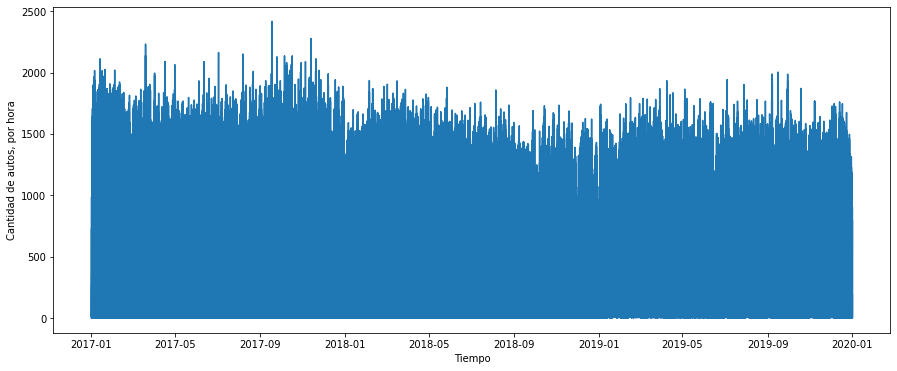

In [ ]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [75]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 2)


,periodo,cantidad_pasos
fecha,,
2017-01-01,465927,31183
2017-01-02,637372,51568
2017-01-03,619219,51093
2017-01-04,647457,53332
2017-01-05,641406,56486


Verifico si hay valores faltantes en el resampleo

In [76]:
diario.isna().sum()

periodo           0
cantidad_pasos    0
dtype: int64

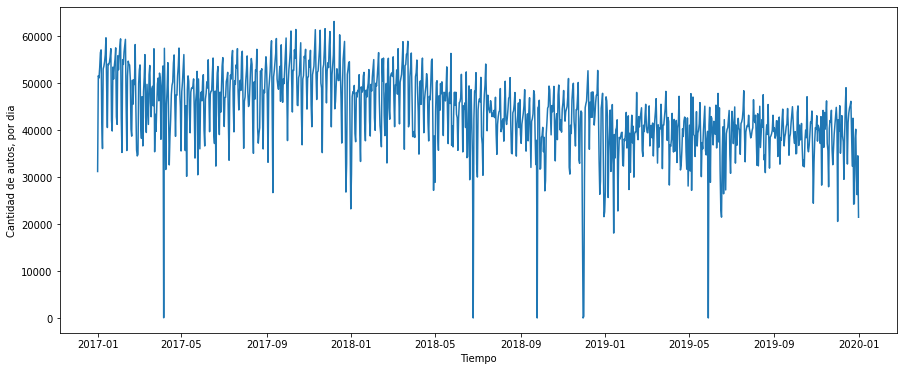

In [27]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Flujo de tránsito por peaje Illia determinado por día que permite una mejor visualización de los datos. Podemos observar valores cercanos a 0 que pueden corresponder a valores faltantes.

# **PARTE A - Exploración de datos**

In [77]:
diario.reset_index(inplace=True)

Verifico la diferencia entre las fechas para ver si están en orden cronológico

In [ ]:
diario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha           1095 non-null   datetime64[ns]
 1   cantidad_pasos  1095 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 17.2 KB


Chequeo los estadísticos 

In [ ]:
diario.describe()

,cantidad_pasos
count,1089.000000
mean,43953.343434
std,7544.988498
min,18076.000000
25%,39135.000000
50%,43811.000000
75%,49524.000000
max,63127.000000


Realizo un boxplot para intentar observar la presencia de outliers.

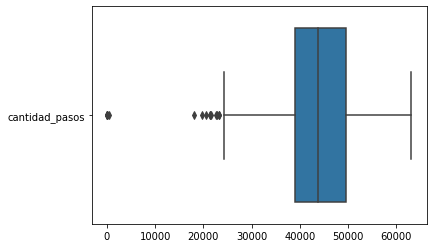

In [ ]:
sns.boxplot(data=diario, orient= "horizontal")
plt.show()

Genero un filtro para estudiar en profundidad estos outliers.

In [ ]:
valores_atipicos = diario[diario.cantidad_pasos<=23000]
valores_atipicos

,fecha,periodo,cantidad_pasos
95,2017-04-06,6051,40
540,2018-06-25,0,0
632,2018-09-25,0,0
697,2018-11-29,387456,19728
698,2018-11-30,0,0
699,2018-12-01,22198,350
728,2018-12-30,312790,21559
729,2018-12-31,399564,22599
742,2019-01-13,121140,18076
748,2019-01-19,151425,22774


Investigación de días con frecuencia vehicular atipica

Ya que estamos trabajando con una serie de tiempo solo tomaremos los días con número de pasos menor a 1000 como valores atipicos de la serie, debido a que los días restantes presentan cifras muy cercanas al primer cuartil de la distribución.

De acuerdo a lo anterior se investigo sobre estos días y observamos que son valores perdidos y que el poco o nulo fluho vehicular se debe a lo siguiente:

6 abril 2017: Paro nacional por la convocatoria de la Confederación General del Trabajo (CGT) a una huelga nacional, la primera que los sindicatos peronistas declaran al presidente Mauricio Macri.

25 junio 2018: Tercer paro general contra la gestión de Mauricio Macri

25 septiembre 2018: Cuarto paro general contra la gestión de Mauricio Macri

30 noviembre 2018: Día feriado por motivo de la cumbre del G20

1 de diciembre 2018: Apertura de autopista 10 pm por motivo de la Cumbre G20

29 mayo de 2019: Quinto paro general contra el presidente Mauricio Marcri

**Imputación de Valores Faltantes**


In [78]:
diario.cantidad_pasos[diario.cantidad_pasos <= 1000] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
print(diario.isna().sum())
diario = diario.interpolate()
print(diario.isna().sum())

fecha             0
periodo           0
cantidad_pasos    6
dtype: int64
fecha             0
periodo           0
cantidad_pasos    0
dtype: int64


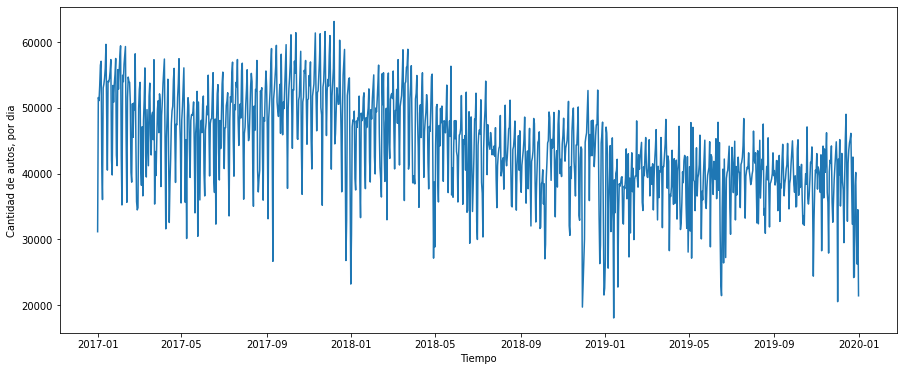

In [31]:
plt.figure(figsize = (15,6))
plt.plot(diario.fecha, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Agrupo los datos para ver que días son los de mayor flujo vehicular. 

In [32]:
dias_trafico = pd.DataFrame(dataset.groupby('dia', sort= True)["dia"].count().reset_index(name = "Total"))
dias_trafico.sort_values(by= ["Total"], ascending = False, inplace= True, ignore_index = True)
dias_trafico

,dia,Total
0,Viernes,35196
1,Miércoles,35005
2,Jueves,34914
3,Martes,34335
4,Lunes,34144
5,Sábado,33351
6,Domingo,31924


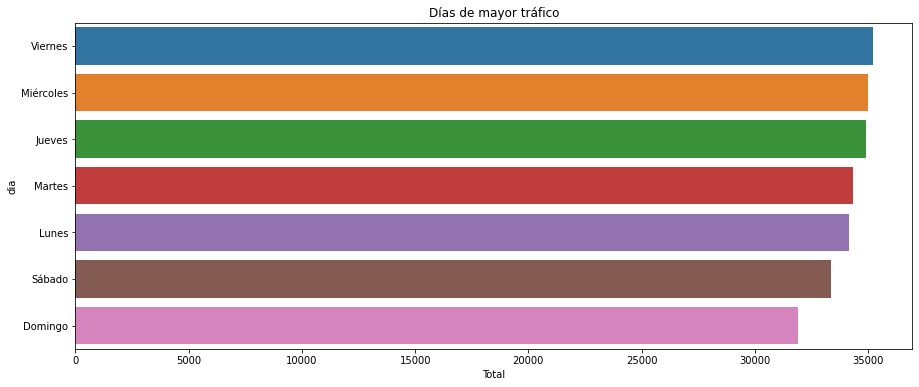

In [ ]:
plt.figure(figsize = (15,6))
sns.barplot(data = dias_trafico, x= "Total", y= "dia", orient= "h")
plt.title('Días de mayor tráfico')
plt.tight_layout
plt.show()

Puede verse que encabeza la lista de mayor frecuencia semanal el día viernes ya sea porque se puede aglomerar la gente que trabaja en el centro y regresa a su casa, sumado a los que ocasionalmente viajen por fin de semana saliendo un viernes. 
Con menor frecuencia tenemos los días sábados y domingos, ya que esos días el flujo de tránsito por temas laborales es claramente menor que en días hábiles.

In [80]:
# Genero una columna 'dia' para luego crear máscaras por días y ver promedios, entre otras cosas
diario_dia = diario.copy()
diario_dia['dia'] = diario_dia['fecha'].dt.dayofweek
diario_dia

,fecha,periodo,cantidad_pasos,dia
0,2017-01-01,465927,31183.0,6
1,2017-01-02,637372,51568.0,0
2,2017-01-03,619219,51093.0,1
3,2017-01-04,647457,53332.0,2
4,2017-01-05,641406,56486.0,3
...,...,...,...,...
1090,2019-12-27,193824,40182.0,4
1091,2019-12-28,193824,30681.0,5
1092,2019-12-29,193824,26259.0,6
1093,2019-12-30,191805,34523.0,0


In [ ]:
#diario['cantidad_pasos'] = diario['cantidad_pasos'].astype(int)

Ahora genero un dataset por cada día de la semana para hacer algunos análisis más.

In [81]:
#Lunes
mascara_dia = diario_dia.dia==0
dataset_lunes = diario_dia[mascara_dia]
#Martes
mascara_dia = diario_dia.dia==1
dataset_martes = diario_dia[mascara_dia]
#Miércoles
mascara_dia = diario_dia.dia==2
dataset_miercoles = diario_dia[mascara_dia]
#Jueves
mascara_dia = diario_dia.dia==3
dataset_jueves = diario_dia[mascara_dia]
#Viernes
mascara_dia = diario_dia.dia==4
dataset_viernes = diario_dia[mascara_dia]
#Sábado
mascara_dia = diario_dia.dia==5
dataset_sabado = diario_dia[mascara_dia]
#Domingo
mascara_dia = diario_dia.dia==6
dataset_domingo = diario_dia[mascara_dia]

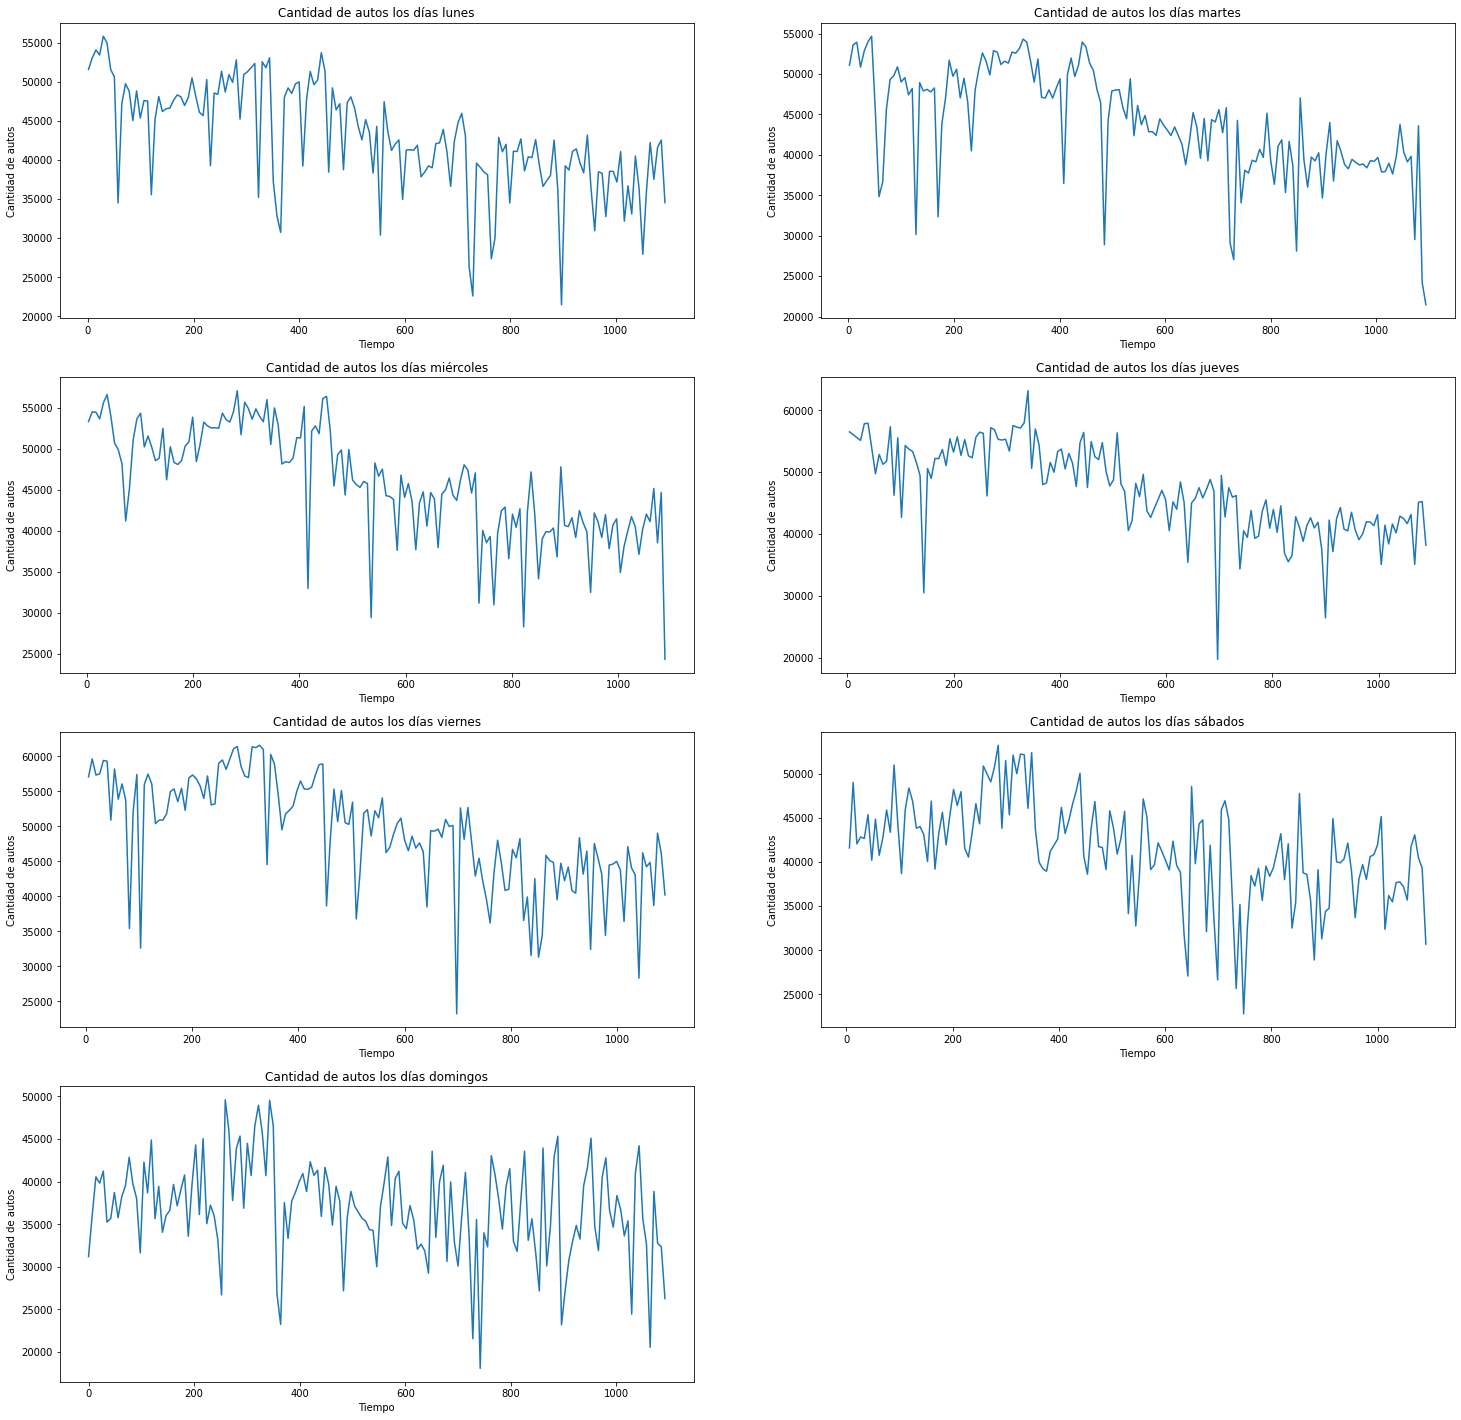

In [35]:
plt.figure(figsize=(25,25))

plt.subplot(4,2,1)
plt.plot(dataset_lunes.index, dataset_lunes.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos los días lunes')

plt.subplot(4,2,2)
plt.plot(dataset_martes.index, dataset_martes.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos los días martes')

plt.subplot(4,2,3)
plt.plot(dataset_miercoles.index, dataset_miercoles.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos los días miércoles')

plt.subplot(4,2,4)
plt.plot(dataset_jueves.index, dataset_jueves.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos los días jueves')

plt.subplot(4,2,5)
plt.plot(dataset_viernes.index, dataset_viernes.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos los días viernes')

plt.subplot(4,2,6)
plt.plot(dataset_sabado.index, dataset_sabado.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos los días sábados')

plt.subplot(4,2,7)
plt.plot(dataset_domingo.index, dataset_domingo.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos los días domingos')

plt.tight_layout
plt.show()

Se puede visualizar que los mayores agrupamientos de vehículos se dan en las horas picos, debido a la fuerte circulación de personas que regresan de sus trabajos. 
El gráfico del día domingo es mucho más ruidoso porque al ser un día no laboral la gente que circula en plan de paseo, no maneja un horario fijo para transitar por la ciudad.

In [36]:
print('Cantidad de autos los días Lunes:'+str(int(dataset_lunes.cantidad_pasos.sum())))
print('Cantidad de autos promedio los días Lunes:'+str(int(dataset_lunes.cantidad_pasos.mean())))
print('---------------------------------------------------------------------')
print('Cantidad de autos los días Martes:'+str(int(dataset_martes.cantidad_pasos.sum())))
print('Cantidad de autos promedio los días Martes:'+str(int(dataset_martes.cantidad_pasos.mean())))
print('---------------------------------------------------------------------')
print('Cantidad de autos los días Miércoles:'+str(int(dataset_miercoles.cantidad_pasos.sum())))
print('Cantidad de autos promedio los días Miércoles:'+str(int(dataset_miercoles.cantidad_pasos.mean())))
print('---------------------------------------------------------------------')
print('Cantidad de autos los días Jueves:'+str(int(dataset_jueves.cantidad_pasos.sum())))
print('Cantidad de autos promedio los días Jueves:'+str(int(dataset_jueves.cantidad_pasos.mean())))
print('---------------------------------------------------------------------')
print('Cantidad de autos los días Viernes:'+str(int(dataset_viernes.cantidad_pasos.sum())))
print('Cantidad de autos promedio los días Viernes:'+str(int(dataset_viernes.cantidad_pasos.mean())))
print('---------------------------------------------------------------------')
print('Cantidad de autos los días Sábado:'+str(int(dataset_sabado.cantidad_pasos.sum())))
print('Cantidad de autos promedio los días Sábado:'+str(int(dataset_sabado.cantidad_pasos.mean())))
print('---------------------------------------------------------------------')
print('Cantidad de autos los días Domingo:'+str(int(dataset_domingo.cantidad_pasos.sum())))
print('Cantidad de autos promedio los días Domingo:'+str(int(dataset_domingo.cantidad_pasos.mean())))

Cantidad de autos los días Lunes:6729699
Cantidad de autos promedio los días Lunes:42864
---------------------------------------------------------------------
Cantidad de autos los días Martes:6906850
Cantidad de autos promedio los días Martes:43992
---------------------------------------------------------------------
Cantidad de autos los días Miércoles:7165879
Cantidad de autos promedio los días Miércoles:45935
---------------------------------------------------------------------
Cantidad de autos los días Jueves:7357666
Cantidad de autos promedio los días Jueves:47164
---------------------------------------------------------------------
Cantidad de autos los días Viernes:7670449
Cantidad de autos promedio los días Viernes:49169
---------------------------------------------------------------------
Cantidad de autos los días Sábado:6467991
Cantidad de autos promedio los días Sábado:41461
---------------------------------------------------------------------
Cantidad de autos los días D

Acá está plasmado en números lo que visualizamos en gráfico más arriba con el dataframe "dias_trafico" para observar en números los días de mayor frecuencia en la semana y como los fines de semana esta misma disminuye a causa de la menor actividad laboral.

**Resampleo por frecuencia semanal**

In [82]:
semanal = dataset.resample('W', on = 'fecha').sum()
print(semanal.shape)
semanal.head()

(158, 2)


,periodo,cantidad_pasos
fecha,,
2017-01-01,465927,31183
2017-01-08,4395043,347212
2017-01-15,4399077,366413
2017-01-22,4421264,357215
2017-01-29,4427315,354581


***Autocorrelación*** 

In [83]:
semanal.drop(columns=['periodo'],inplace=True)

In [84]:
# Voy a abarcar un rango de fecha de 3 años hacia atrás (52 son las semanas que tiene cada año)
nlags = 52*3
autocorr = acf(semanal, nlags = nlags)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



In [41]:
autocorr.shape

(157,)

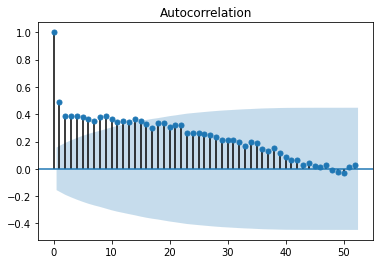

In [42]:
plot_acf(semanal.cantidad_pasos, lags=52)
plt.show()

Podemos ver varios componentes autocorrelacionados, una porción está fuera del intervalo de confianza, mostrando que son significativos. Nos da la pauta de que sería bueno aplicar un modelo autoregresivo. 

***Autocorrelación parcial*** 

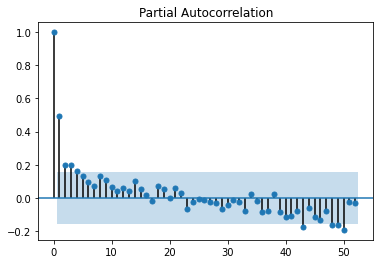

In [43]:
plot_pacf(semanal.cantidad_pasos, lags=52)
plt.show()

Si bien se ven patrones significativos, los más importantes son al principio. Se ve una fuerte correlación de a pares entre las primeras fechas (entre una día y el siguiente), luego sigue siendo significativo pero va disminuyendo a medida que nos desplazamos en la serie.

In [85]:
diario = diario.set_index('fecha')
diario

,periodo,cantidad_pasos
fecha,,
2017-01-01,465927,31183.0
2017-01-02,637372,51568.0
2017-01-03,619219,51093.0
2017-01-04,647457,53332.0
2017-01-05,641406,56486.0
...,...,...
2019-12-27,193824,40182.0
2019-12-28,193824,30681.0
2019-12-29,193824,26259.0


**Componentes de la serie**

In [45]:
result = seasonal_decompose(diario.cantidad_pasos, model = 'additive')

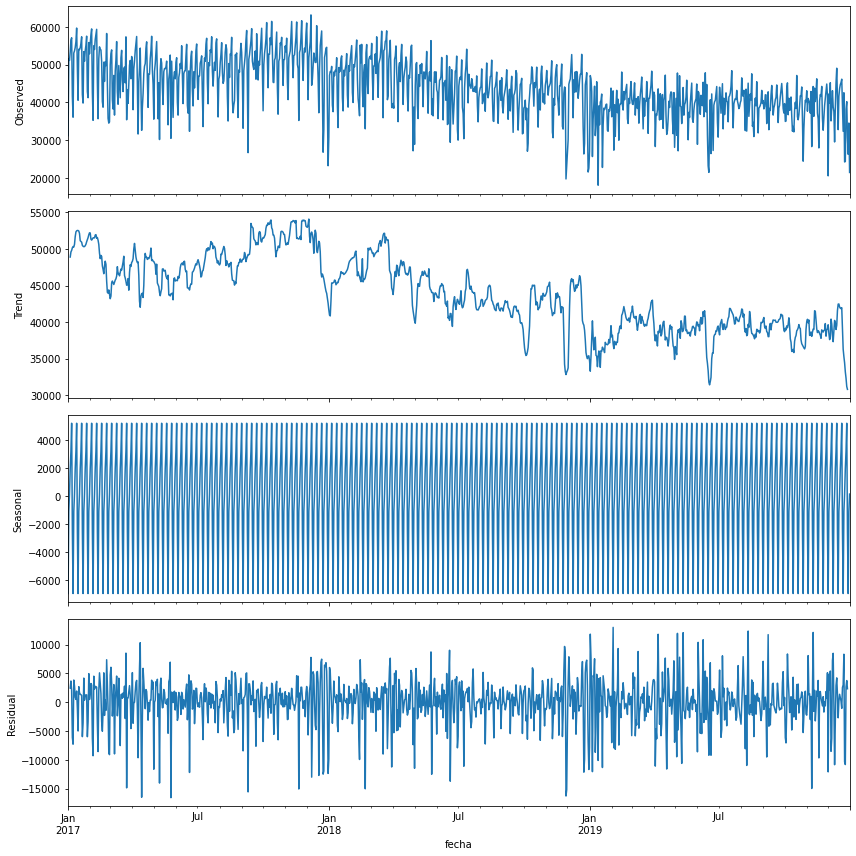

In [46]:
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

Se puede ver que la tendencia fue decayendo con la metodología de pago efectivo, vamos a intentar averiguar cuál fue el motivo.

In [47]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'TELEPASE')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#dataset.drop(columns = ['hora_inicio','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_tel = dataset.resample('D', on = 'fecha').sum()
print(diario_tel.shape)
diario_tel.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,12326
2017-01-02,35621
2017-01-03,39390
2017-01-04,40294
2017-01-05,41373


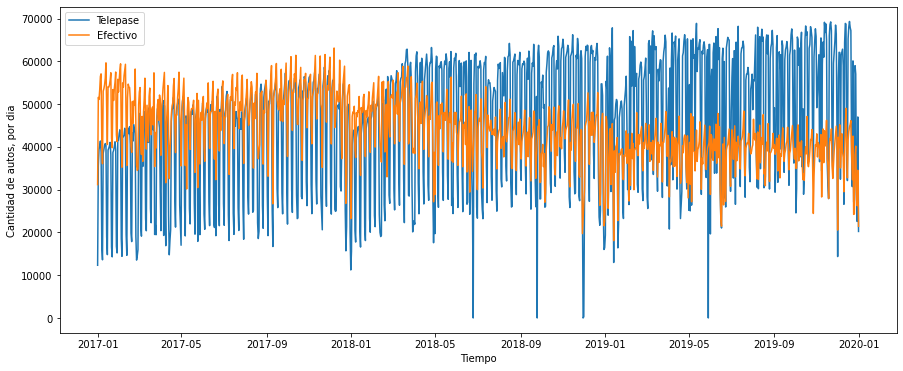

In [48]:
plt.figure(figsize = (15,6))
plt.plot(diario_tel.index, diario_tel.cantidad_pasos, label= 'Telepase')
plt.plot(diario.index, diario.cantidad_pasos, label= 'Efectivo')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.legend()
plt.show()

El Telepase en las autopista de Buenos Aires se inauguró el 19 de Diciembre de 2016. Hoy más del 60 % de los automovilistas lo utilizan y ya es obligatorio para circular no sólo en Capital Federal sino también por ejemplo en la red de accesos a Córdoba. En este gráfico podemos observar el cambio en la tendencia del uso de efectivo a telepase. Seguramente en los próximos meses observaremos solo pago con este último sistema.

Ahora evalúo los componentes de la serie por día, como hicimos más arriba para visualizar la cantidad de movimiento por día 

In [52]:
result_lunes = seasonal_decompose(dataset_lunes.cantidad_pasos, model= 'additive')
result_martes = seasonal_decompose(dataset_martes.cantidad_pasos, model= 'additive')
result_miercoles = seasonal_decompose(dataset_miercoles.cantidad_pasos, model= 'additive')
result_jueves = seasonal_decompose(dataset_jueves.cantidad_pasos, model= 'additive')
result_viernes = seasonal_decompose(dataset_viernes.cantidad_pasos, model= 'additive')
result_sabado = seasonal_decompose(dataset_sabado.cantidad_pasos, model= 'additive')
result_domingo = seasonal_decompose(dataset_domingo.cantidad_pasos, model= 'additive')

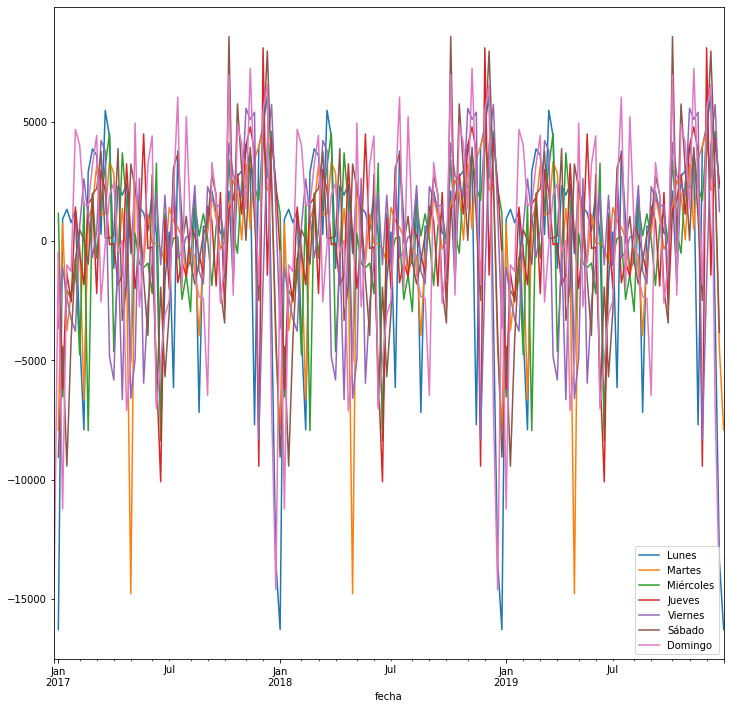

In [53]:
#Estacionalidad

result_lunes.seasonal.plot(legend= 'Lunes', label= 'Lunes')
result_martes.seasonal.plot(legend= 'Martes', label= 'Martes')
result_miercoles.seasonal.plot(legend= 'Miércoles', label= 'Miércoles')
result_jueves.seasonal.plot(legend= 'Jueves', label= 'Jueves')
result_viernes.seasonal.plot(legend= 'Viernes', label= 'Viernes')
result_sabado.seasonal.plot(legend= 'Sábado', label= 'Sábado')
result_domingo.seasonal.plot(legend= 'Domingo', label= 'Domingo')
plt.show()

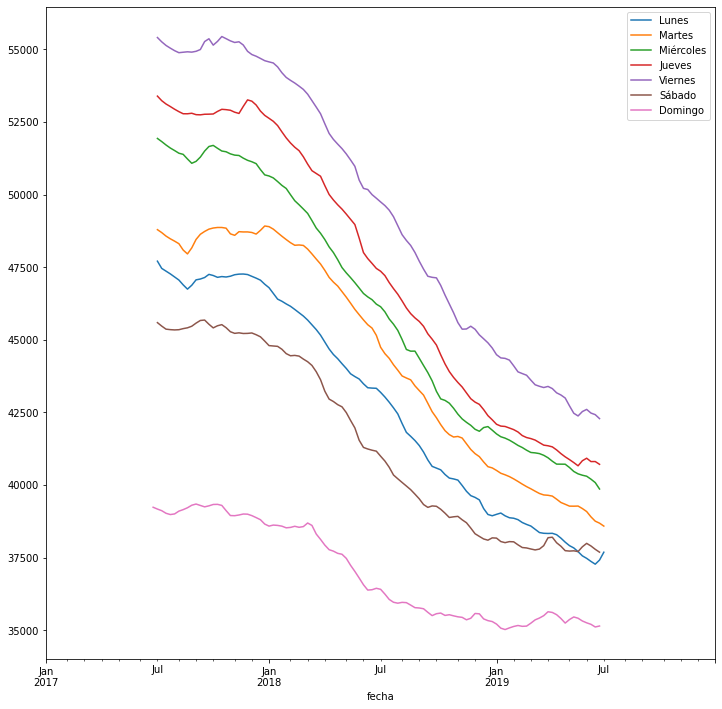

In [54]:
#Tendencia

result_lunes.trend.plot(legend= 'Lunes', label= 'Lunes')
result_martes.trend.plot(legend= 'Martes', label= 'Martes')
result_miercoles.trend.plot(legend= 'Miércoles', label= 'Miércoles')
result_jueves.trend.plot(legend= 'Jueves', label= 'Jueves')
result_viernes.trend.plot(legend= 'Viernes', label= 'Viernes')
result_sabado.trend.plot(legend= 'Sábado', label= 'Sábado')
result_domingo.trend.plot(legend= 'Domingo', label= 'Domingo')
plt.show()

Como vimos más arriba en el gráfico general, la tendencia de método de pago efectivo con el tiempo fue decreciendo a causa de la aparición del telepase.

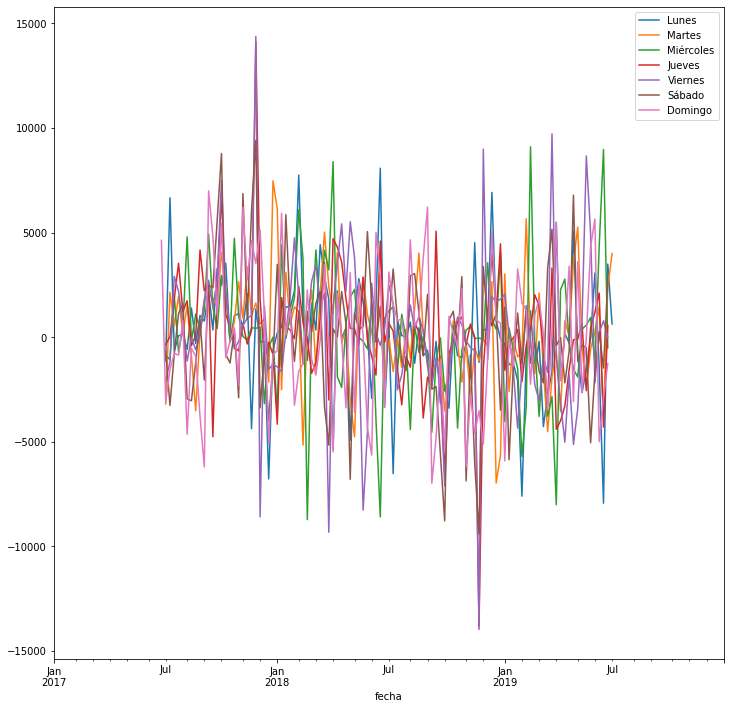

In [55]:
#Ruido

result_lunes.resid.plot(legend= 'Lunes', label= 'Lunes')
result_martes.resid.plot(legend= 'Martes', label= 'Martes')
result_miercoles.resid.plot(legend= 'Miércoles', label= 'Miércoles')
result_jueves.resid.plot(legend= 'Jueves', label= 'Jueves')
result_viernes.resid.plot(legend= 'Viernes', label= 'Viernes')
result_sabado.resid.plot(legend= 'Sábado', label= 'Sábado')
result_domingo.resid.plot(legend= 'Domingo', label= 'Domingo')
plt.show()

Procedemos a graficar lo mismo pero descomponiendo semanalmente para tener otra visión de los gráficos.

In [56]:
result_semana = seasonal_decompose(semanal.cantidad_pasos, model = 'additive')

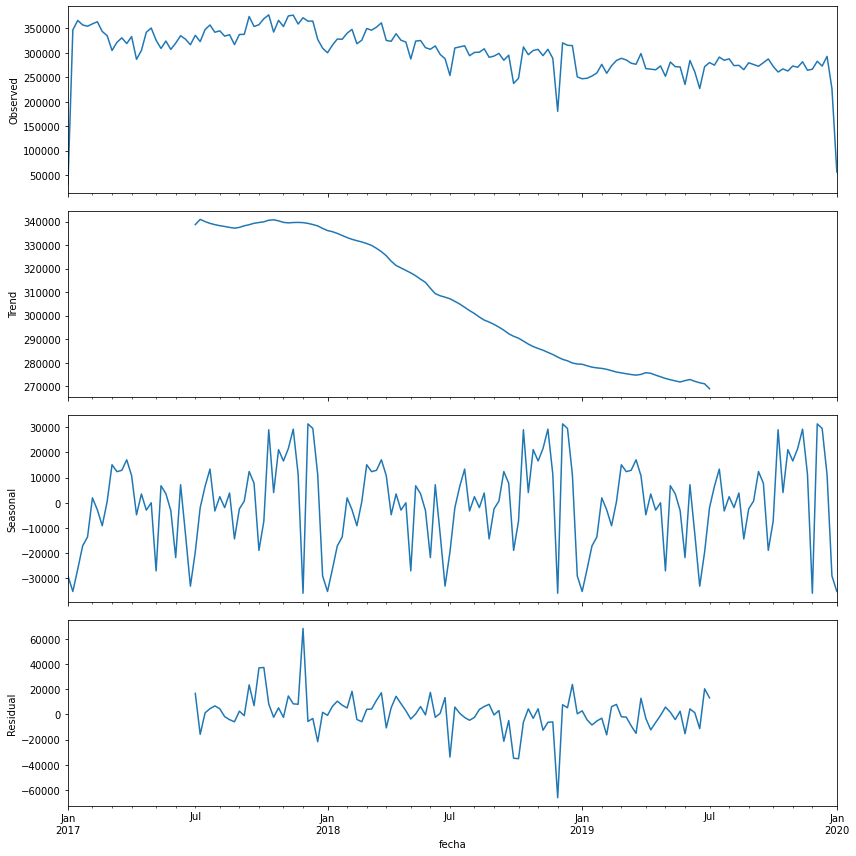

In [57]:
matplotlib.rcParams['figure.figsize'] = [12,12]
result_semana.plot()
plt.show()

**One-Step Prediction**

In [87]:
diario.drop(columns=['periodo'],inplace=True)

In [62]:
diario.head()

,cantidad_pasos,dia
fecha,,
2017-01-01,31183.0,6
2017-01-02,51568.0,0
2017-01-03,51093.0,1
2017-01-04,53332.0,2
2017-01-05,56486.0,3


In [88]:
look_back = 90*1 #usamos x años de datos para predecir el valor siguiente

In [89]:
N = diario.shape[0]
X = np.zeros((N - look_back - 1, look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1004, 90) (1004,)


In [ ]:
N- 365 - 1

729

In [90]:
for i in range(X.shape[0]):
    X[i,:] = diario.values[i:i+look_back].ravel()
    y[i] = diario.values[i+look_back]

In [91]:
N_train = 2*365 - look_back
N_test = 1*365
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test, :]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(640, 90) (640,)
(364, 90) (364,)


In [ ]:
N_total

1005

In [92]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# ***Parte B: Modelo Machine Learning***

**Defino y divido los datos en train y test**

**Métrica**

De acuerdo a los modelos de regresión que voy a probar, utilizaré las siguientes métricas: 


1.   Error cuadrático medio (RMSE)
2.   Error absoluto medio (MSE)






***Modelo Benchmark***

Comparamos el error con el que habríamos obtenido si predecíamos copiando el valor de la fecha anterior.

In [93]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

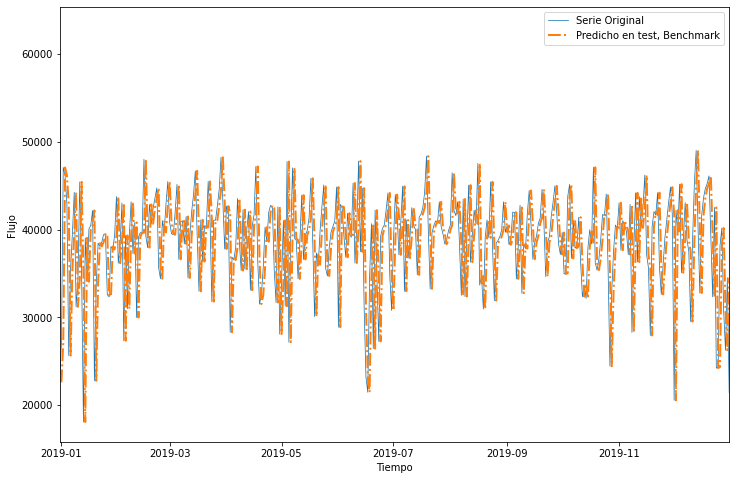

In [94]:
plt.figure(figsize=(12,8))
plt.plot(diario.index[:length_total], diario[:length_total], lw= 0.75, label= 'Serie Original')
plt.plot(diario.index[N_train+look_back:length_total], y_test_pred_benchmark, '-.', lw= 2, label= 'Predicho en test, Benchmark')
plt.xlim(diario.index[N_train+look_back-1], diario.index[length_total-1])
plt.xlabel('Tiempo')
plt.ylabel('Flujo')
plt.legend()
plt.show()

In [ ]:
y_test_pred_benchmark.shape

(365,)

In [95]:
MSE = mean_squared_error(y_test, y_test_pred_benchmark[:-1])
print('Error en test:', np.sqrt(MSE))

Error en test: 6633.905956552641


***Modelo Random Forest***

In [96]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4).fit(X_train, y_train)

In [97]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [ ]:
diario.index[N_train+look_back: length_total].shape

(365,)

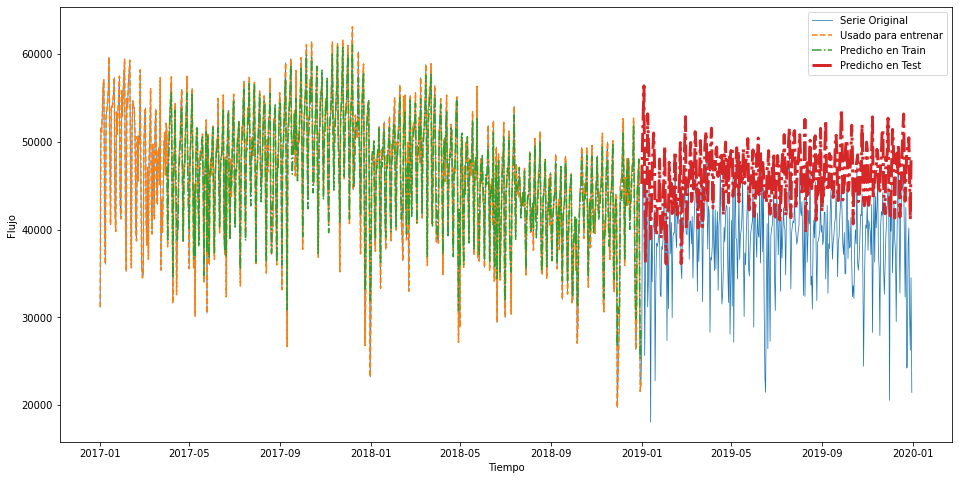

In [98]:
plt.figure(figsize=(16,8))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:N_train + look_back], diario[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 3, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Flujo')
plt.show()

El modelo arroja por el momento un error considerable, si bien es pareja la diferencia entre train y test, vemos que no toma del todo bien los picos de cantidad de pasos para la porción de test con nuestra predicción.

In [99]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:', np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:', np.sqrt(MSE))

Error en Train: 1775.035559902461
Error en Test: 8940.639141846252


Raíz del error cuadrático medio en Train:1775.035559902461
Raíz del error cuadrático medio en Test:8940.639141846252


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



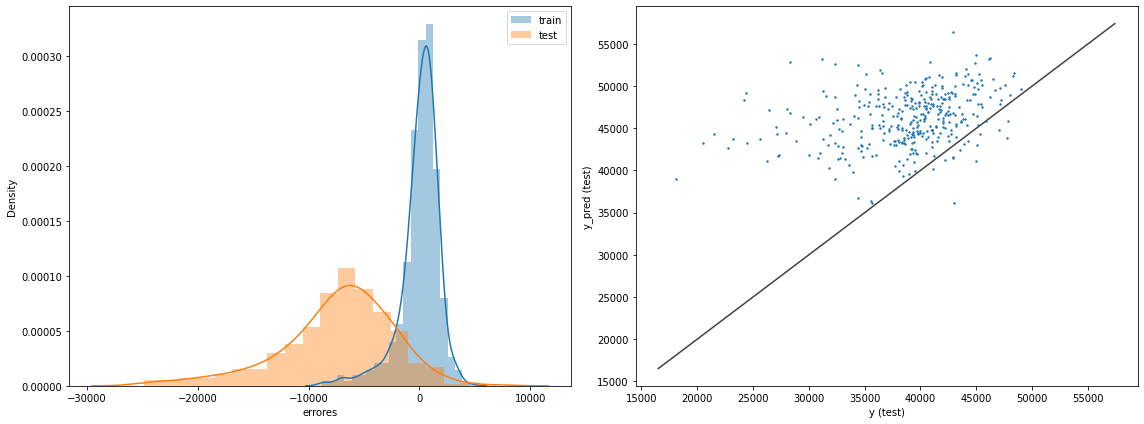

In [100]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train:{rmse_train}')
print(f'Raíz del error cuadrático medio en Test:{rmse_test}')

plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()
    
ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

Como mencioné, el modelo no fue bueno en cuanto a resultados. Se observa que el modelo aprendió muy bien en el conjunto de train pero no así en test donde sobreestimó mucho más que en train. El error en test es mucho más sistemático que en train.

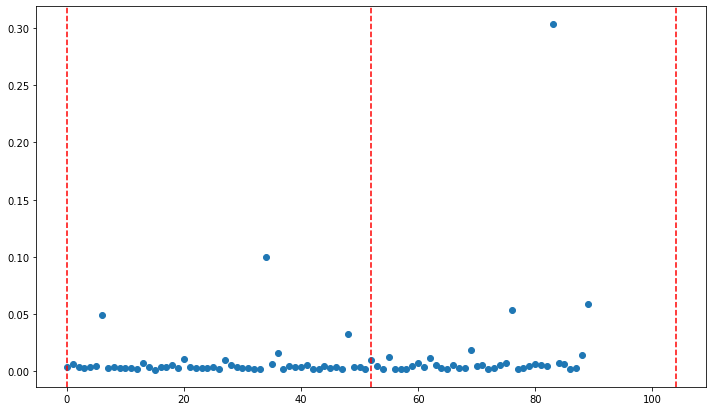

In [101]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
for x in np.arange(3)*52:
    plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

El modelo utiliza los últimos días (algún día en particular despues del día 80 sobre todo) antes del día 1 de nuestro modelo como los mejores estimadores para predecir.

***XGBoost: Extreme Gradient Boosting***

In [102]:
xgb_reg = xgb.XGBRegressor()
param_search = {'max_depth':[3,5]}

#Optimización de hiperparámetros

tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=xgb_reg, cv=tscv, scoring='neg_mean_squared_error',
                       param_grid = param_search)
gsearch.fit(X_train, y_train)

[19:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None, param_grid={'max_depth': [3, 5]},
             pre_dispatch='2*n_jobs', 

In [103]:
y_train_pred = gsearch.predict(X_train)
y_test_pred = gsearch.predict(X_test)

In [ ]:
y_train_pred.shape

(640,)

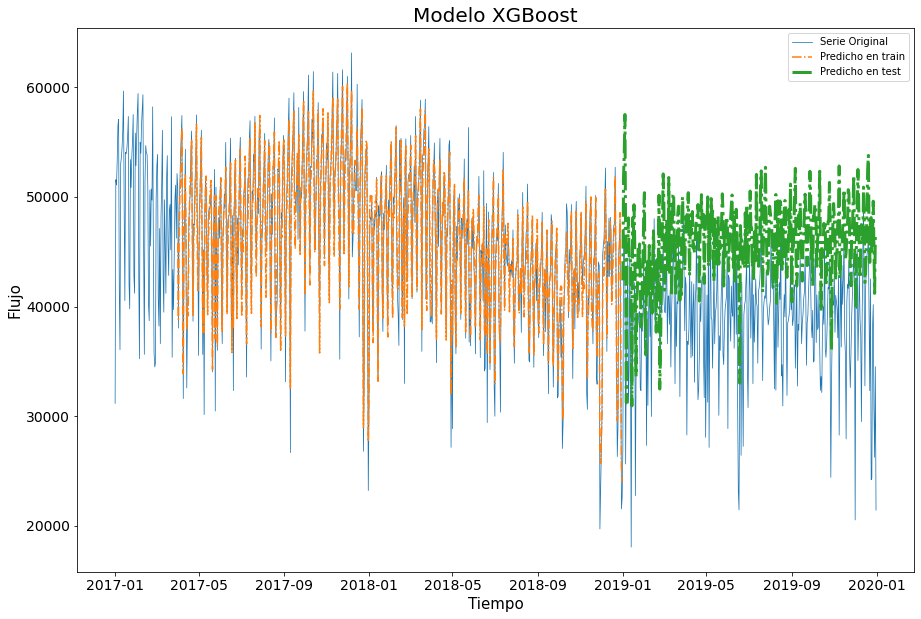

In [104]:
plt.figure(figsize=(15,10))
plt.plot(diario.index[:length_total], diario[:length_total], lw=0.75, label= 'Serie Original')
plt.plot(diario.index[look_back:look_back+N_train], y_train_pred, '-.', label= 'Predicho en train')
plt.plot(diario.index[N_train+look_back:length_total-1], y_test_pred, '-.', lw=3, label= 'Predicho en test')
#Formato de gráfico 
plt.title('Modelo XGBoost', fontsize=20)
plt.xlabel('Tiempo', fontsize=15)
plt.ylabel('Flujo',fontsize=15)
plt.legend(loc='center left')
plt.tick_params(labelsize=14)
plt.legend()
plt.show()

Se puede ver en el resultado de este gráfico, dado el overfitting de este modelo vemos que porción de train la toma muy bien para la parte predicha. 
No así para lo que es test, el último trismestre que intentamos predecir vemos que el resultado fue muy pobre.

In [105]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:', np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:', np.sqrt(MSE))

Error en Train: 2073.959639028041
Error en Test: 8801.309137307753


Raíz del error cuadrático medio en Train:2073.959639028041
Raíz del error cuadrático medio en Test:8801.309137307753


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



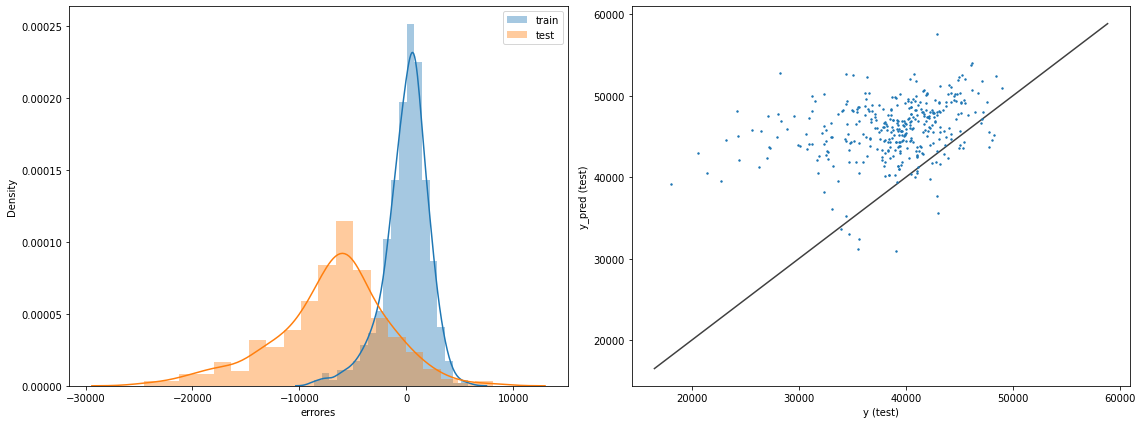

In [106]:
y_train_pred = gsearch.predict(X_train)
y_test_pred = gsearch.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train:{rmse_train}')
print(f'Raíz del error cuadrático medio en Test:{rmse_test}')

plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()
    
ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

El resultado del modelo es bastante inferior en cuanto a calidad, respecto de nuestro benchmark, ya que la serie de tiempo es muy errática y tiene bastante ruido y esto afectó nuestro modelo XGBoost.
Posee un overfiting bastante marcado. 

In [107]:
tscv = TimeSeriesSplit(5)
for i, (train, test) in enumerate(tscv.split(X_train, y_train)):
    print("Class ocurrences in train split #%d: %s" %
            (i, y_train[train].shape))
    print("Class ocurrences in test split #%d: %s" %
            (i, y_train[test].shape))

Class ocurrences in train split #0: (110,)
Class ocurrences in test split #0: (106,)
Class ocurrences in train split #1: (216,)
Class ocurrences in test split #1: (106,)
Class ocurrences in train split #2: (322,)
Class ocurrences in test split #2: (106,)
Class ocurrences in train split #3: (428,)
Class ocurrences in test split #3: (106,)
Class ocurrences in train split #4: (534,)
Class ocurrences in test split #4: (106,)


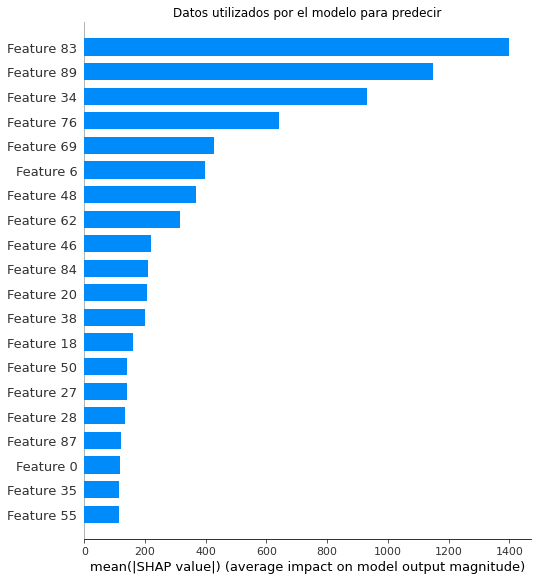

In [108]:
model = gsearch.best_estimator_
shap_values = shap.TreeExplainer(model).shap_values(X_train)
plt.title('Datos utilizados por el modelo para predecir')
shap.summary_plot(shap_values, X_train, plot_type="bar")

El modelo utiliza los días 83, 89, 34 y 76 como los mejores estimadores para predecir.

***Predicción 2020***

In [112]:
data_2020 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/flujo-vehicular-2020.csv', sep =',')

In [ ]:
data_2020.info()
data_2020.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         float64
 1   fecha           object 
 2   mes             object 
 3   dia             object 
 4   dia_fecha       float64
 5   hora_inicio     float64
 6   hora_fin        float64
 7   estacion        object 
 8   tipo_vehiculo   object 
 9   forma_pago      object 
 10  observacion     object 
 11  sentido         object 
 12  cantidad_pasos  float64
dtypes: float64(5), object(8)
memory usage: 251.3+ MB


,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Centro,24.0
1,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80.0
2,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1.0
3,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1.0
4,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1.0


In [113]:
data_2020['periodo'] = data_2020['periodo'].astype(int)
data_2020['cantidad_pasos'] = data_2020['cantidad_pasos'].astype(int)

In [114]:
data_2020.forma_pago.replace({'Efectivo': 'EFECTIVO','Tarjeta Magnética':'TELEPASE','Tag':'TELEPASE'},
                             inplace=True)

In [115]:
data_2020.estacion.replace({'ALBERDI':'Alberdi','AVELLANEDA':'Avellaneda','ILLIA':'Illia','RETIRO':'Retiro',
                            'SARMIENTO':'Sarmiento','SALGUERO':'Salguero','DELLEPIANE LINIERSLEPIANE CENTRO':
                           'Dellepiane Centro','DELLEPIANE LINIERS':'Dellepiane Liniers'},inplace=True)

In [116]:
data_2020.tipo_vehiculo.replace({'Pesado 2 Ejes':'Pesado','Pesado 3 Ejes':'Pesado','Pesado 4 Ejes':'Pesado',
                                 'Pesado 5 Ejes':'Pesado','Pesados 6 Ejes':'Pesado'},inplace=True)

In [117]:
data_2020.drop(columns=['mes','observacion','dia_fecha'], inplace = True)

In [118]:
#Unimos los 4 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2020, data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#dataset.drop(columns = ['hora_inicio','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_20 = dataset.resample('D', on = 'fecha').sum()
print(diario_20.shape)
diario_20.head()

(1461, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


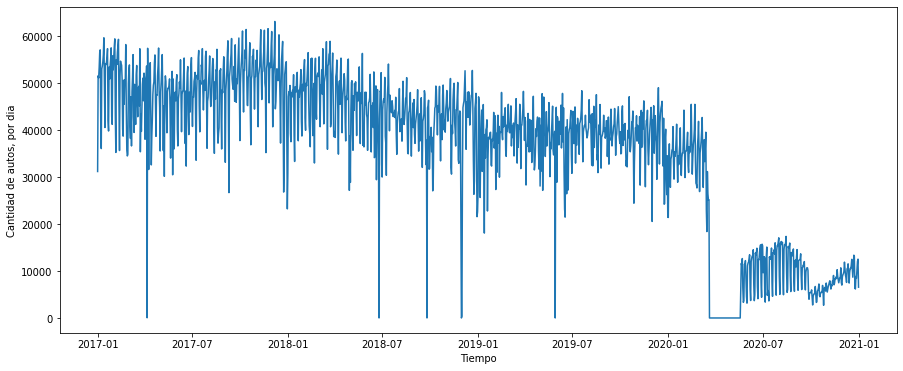

In [119]:
plt.figure(figsize = (15,6))
plt.plot(diario_20.index, diario_20.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Observamos en el gráfico detallado por día que a medida que se van levantando las restricciones de circulación aumenta el flujo en la autopista

In [120]:
look_back = 90*1

In [121]:
N_20 = diario_20.shape[0]
X_20 = np.zeros((N_20 - look_back - 1, look_back))
y_20 = np.zeros(N_20 - look_back - 1)
print((X_20.shape, y_20.shape))

((1370, 90), (1370,))


In [122]:
N_20

1461

In [125]:
N_20-365-1

1095

In [123]:
for i in range(X_20.shape[0]):
    X_20[i,:] = diario_20.values[i:i+look_back].ravel()
    y_20[i] = diario_20.values[i+look_back]

In [124]:
#X_20.shape

In [126]:
#y_20.shape

In [127]:
N_train_20 = 3*365 - look_back

X_test_20 = X_20[N_train_20:, :]
y_test_20 = y_20[N_train_20:]
print(X_test_20.shape, y_test_20.shape)

(365, 90) (365,)


In [128]:
#Subset2020
#N_train_20 = 3*365 - look_back
#N_test_20 = 1*365
#N_total_20 = N_train_20 + N_test_20

#length_total = N_train_20 + N_test_20 + look_back

#X_train_20 = X[:N_train_20,:]
#y_train_20 = y[:N_train_20]
#print(X_train_20.shape, y_train_20.shape)

#X_test_20 = X[N_train_20:N_train_20+N_test_20, :]
#y_test_20 = y[N_train_20:N_train_20+N_test_20]
#print(X_test_20.shape, y_test_20.shape)

In [129]:
#N_total_20

In [130]:
#scaler = StandardScaler()
#X_train_20 = scaler.transform(X_train_20)
X_test_20 = scaler.transform(X_test_20)

***Modelo Benchmark 2020***

In [ ]:
#y_test_pred_benchmark_20 = y[-1 + N_train_20:N_train_20+N_test_20 - 1]

In [131]:
#y_test_pred_benchmark_20.shape

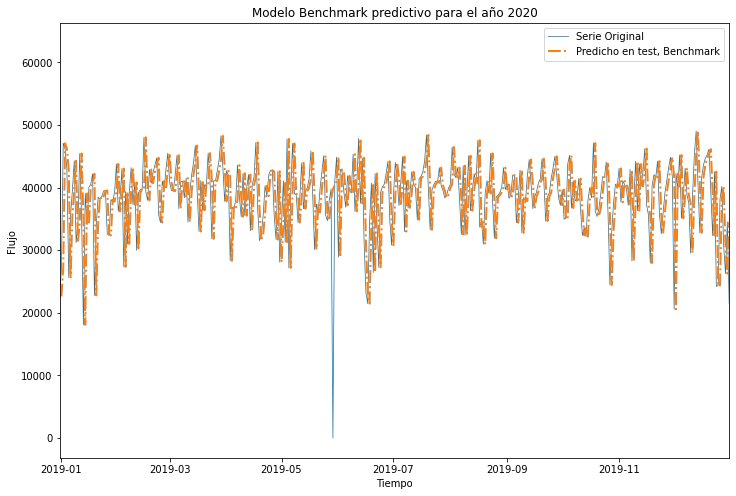

In [132]:
plt.figure(figsize=(12,8))
plt.plot(diario_20.index[:length_total], diario_20[:length_total], lw= 0.75, label= 'Serie Original')
plt.plot(diario_20.index[N_train+look_back:length_total], y_test_pred_benchmark, '-.', lw= 2, label= 'Predicho en test, Benchmark')
plt.xlim(diario_20.index[N_train+look_back-1], diario_20.index[length_total-1])
plt.title('Modelo Benchmark predictivo para el año 2020')
plt.xlabel('Tiempo')
plt.ylabel('Flujo')
plt.legend()
plt.show()

In [13]:
#MSE_20 = mean_squared_error(y_test_20, y_test_pred_benchmark_20[:-1])
#print('Error en test:', np.sqrt(MSE_20))

***Modelo Random Forest 2020***

In [ ]:
#rf_20 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4).fit(X_train_20, y_train_20)

In [133]:
#y_pred_20 = rf_20.predict(X)
#y_train_pred_20 = rf_20.predict(X_train_20)
y_test_pred_20 = rf.predict(X_test_20)

In [14]:
#diario_20.index[N_train+look_back:length_total].shape

In [15]:
#length_total

In [ ]:
y_test_pred_20.shape

(365,)

In [ ]:
diario_20.shape

(1461, 1)

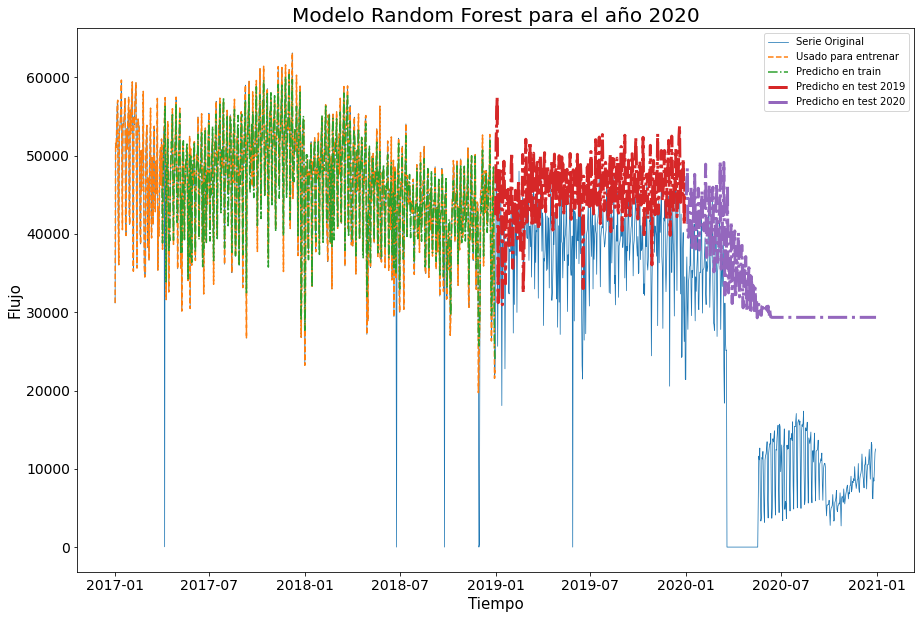

In [134]:
plt.figure(figsize=(15,10))
plt.plot(diario_20.index[:length_total+365], diario_20[:length_total+365], lw=0.75, label= 'Serie Original')
plt.plot(diario.index[:N_train+look_back], diario[:N_train+look_back], '--',label= 'Usado para entrenar')
plt.plot(diario.index[look_back:look_back+N_train], y_train_pred, '-.', label= 'Predicho en train')
plt.plot(diario.index[N_train+look_back:length_total-1], y_test_pred, '-.', lw=3, label= 'Predicho en test 2019')
plt.plot(diario_20.index[-365:], y_test_pred_20, '-.', lw=3, label= 'Predicho en test 2020')
#plt.plot(diario_20.index[-365:], y_test_20, '-.', lw=3, label= 'Observado en test 2020')
#Formato de gráfico 
plt.title('Modelo Random Forest para el año 2020', fontsize=20)
plt.xlabel('Tiempo', fontsize=15)
plt.ylabel('Flujo',fontsize=15)
plt.legend(loc='center left')
plt.tick_params(labelsize=14)
plt.legend()
plt.show()

Podemos observar que al agregar los datos del año 2020, nuestro modelo también empeora su resultado, observandose el aumento en el RMSE y también modificando el gráfico de tendencia de los datos. Probablemente el año 2020 funcione como un "año de valor atípico" o "año outlier" lo que altera notablemente el resultado de nuestro modelo.

In [ ]:
y_test_20.shape

(365,)

In [135]:
#MSE = mean_squared_error(y_train_20, y_train_pred)
#print('Error en Train:', np.sqrt(MSE))

MSE = mean_squared_error(y_test_20, y_test_pred_20)
print('Error en Test:', np.sqrt(MSE))

Error en Test: 21582.59579677079


***Conclusiones***

Como sabemos las series de tiempo brindan la oportunidad de pronosticar valores futuros, basándose en valores anteriores. Se pueden utilizar para pronosticar tendencias. Asumiendo un supuesto: que el futuro se va a comportar como el pasado.
Podemos notar que de los modelos probados, el que mejores resultados arrojó fue el Benchmark que realizamos al principio. 
También podemos inferir que el modelo XGBoost no es de fácil adaptación a las series de tiempo, no obtenemos buenos resultados, ya que las mismas son muy variables a lo largo del tiempo.
Se puede concluir que las series de tiempo hay que analizarlas con mucho detenimiento, puesto que contienen mucha informacion que no es clara a simple vista, que quiere decir esto, una serie de tiempo obedece a un comportamiento de una o mas variablas a traves del tiempo, pero muchas de estas mediciones presentan anomalias por factores ajenos a un control.

# ***Parte C***

De acuerdo a los resultados obtenidos, se puede observar que el modelo Benchmark que utilizamos presentó resultados buenos y mejores que los del modelo optimizado con XGBoost y el modelo de Random Forest.

Lo que me gustaría probar en algún momento es: 


*   Un modelo de Regresión avanzada con atributos polinómicos para probar trabajar con 1 feature e ir agregando los atributos polinómicos. También aplicar regularización para mejorar los resultados.

*   Otros modelos que quisiera probar son ARMA y ARIMA, que son modelos estadísticos y funcionales para series de tiempo. Ya que los modelos de XGBoost y Random Forest que utilizamos, si bien son más actuales, no son modelos especializados en series de tiempo.

*   Como tercer alternativa de prueba, estoy interesado en intentar con algún modelo de redes neuronales, ya que como vimos en la meeting 46, son muy utilizadas para problemas de predicción en series de tiempo debido a que su diseño permite recordar información durante largos períodos y facilita la tarea de hacer estimaciones futuras empleando períodos de registros históricos.





Artículo sobre como aplicar redes neuronales en series de tiempo: 

https://www.apsl.net/blog/2017/06/14/analisis-de-series-temporales-usando-redes-neuronales-recurrentes/

Los resultados que se esperan encontrar, especialmente con redes neuronales, se buscaría una predicción con mayor performance donde el error sea mínimo y la predicción mantenga la misma tendencia que la serie.